In [64]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

In [65]:
import os

folder_path = '../data/'

csv_files = np.array([f for f in os.listdir(folder_path) if f.endswith('.csv')])
csv_files = np.sort(csv_files)[:-1]
print(csv_files)

['2301.csv' '2302.csv' '2303.csv' '2304.csv' '2305.csv' '2306.csv'
 '2307.csv' '2308.csv' '2309.csv' '2310.csv' '2311.csv' '2312.csv'
 '2313.csv' '2314.csv' '2315.csv' '2316.csv' '2317.csv' '2318.csv'
 '2319.csv' '2320.csv' '2321.csv' '2322.csv']


In [66]:
import pandas as pd

In [67]:
df_collar = pd.read_csv("../data/locations.csv")

../data/2304.csv, base freq:75 Hz


Text(0, 0.5, 'Voltage (mV/Am2)')

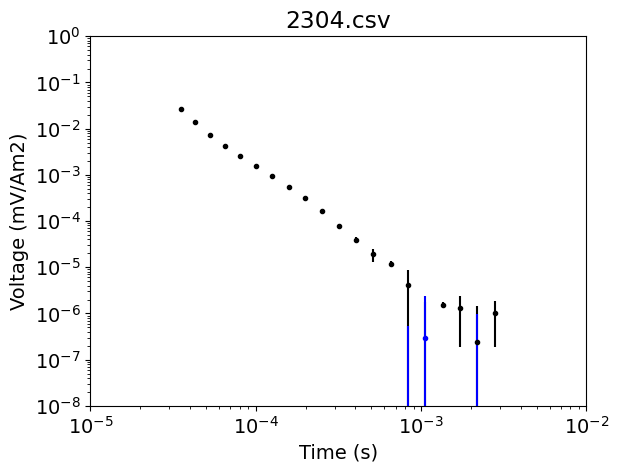

In [68]:
kk = 3
ii = 3
#colors = ['k', 'b']

df = pd.read_csv(folder_path+csv_files[kk])
df_group = df.groupby('f (Hz)')
base_freqs  = list(df_group.groups.keys())

base_freq = base_freqs[ii]
print (f"{folder_path+csv_files[kk]}, base freq:{base_freq:.0f} Hz")
df_tmp = df_group.get_group(base_freq)
i_start_time = 0
voltage = df_tmp['V (mV/Am2)'].values[i_start_time:]
noise = df_tmp['N (mV/Am2)'].values[i_start_time:]
times = df_tmp['Time (s)'].values[i_start_time:]
plt.errorbar(times, voltage, yerr=noise, marker='.', linestyle='None', color='k')
plt.errorbar(times, -voltage, yerr=noise, marker='.', linestyle='None', color='b')
plt.xscale('log')
plt.yscale('log')
# plt.loglog(times, noise, '.')
plt.ylim(1e-8, 1)
plt.xlim(1e-5, 1e-2)
plt.title(csv_files[kk])
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV/Am2)")

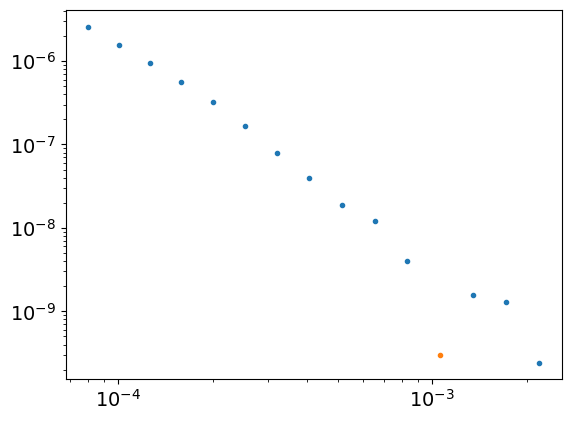

In [69]:
i_time_start = 4
i_time_end = -1
# Source properties
source_location = np.array([0.0, 0.0, 0.1]) # 0.1 m due to protem being on the ground
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 56.4  # source loop radius (chosen from an area of 100x100)

# Receiver properties
receiver_location = np.array([0.0, 0.0, 0.1])
receiver_orientation = "z"  # "x", "y" or "z"
#times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times[i_time_start:i_time_end], orientation=receiver_orientation
    )
)
rampoff_time=5.1e-6 #taken from email thread
freq = 75.0       
T = 1/freq         
I_peak = 1.0       

# calculate times
t1 = -T/2
t2 = t1 + rampoff_time
t3 = -rampoff_time
t4 = 0.0

time_input_current=np.array([t1, t2, t3, t4])
input_current=np.array([0.0, I_peak, I_peak, 0.0])

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.

stepoff_waveform = tdem.sources.PiecewiseLinearWaveform(times=time_input_current, currents=input_current)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=stepoff_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)
# 5% of the absolute value
uncertainties = (0.05 * np.abs(voltage*1e-3) * np.ones(np.shape(voltage*1e-3)))[i_time_start:i_time_end]
dobs = -voltage[i_time_start:i_time_end]*1e-3
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)
plt.loglog(times[i_time_start:i_time_end], -data_object.dobs, '.')
plt.loglog(times[i_time_start:i_time_end], +data_object.dobs, '.')

In [70]:
len(times)

20

In [71]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.001

# minimum diffusion distance
d_min = 1250 * np.sqrt(times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 234.68729194398233 m
MAXIMUM DIFFUSION DISTANCE: 2088.6598574205423 m


In [72]:
depth_min = 1.8  # top layer thickness
depth_max = 300.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [73]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers
print(n_layers)


25


In [74]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [75]:
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

In [76]:
#n_layers_model = len(layer_thicknesses_model) + 1

In [77]:
source_area = 10000

In [78]:
m_rec = np.load("m_rec_4m_rec.npy")

In [79]:
sigma_rec = log_conductivity_map * m_rec

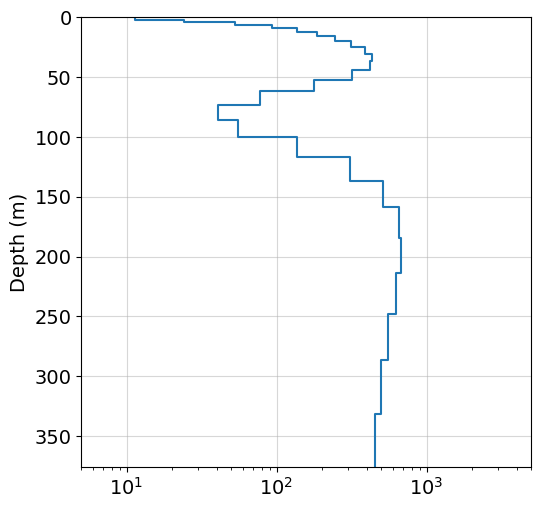

In [80]:
ax = plot_1d_layer_model(layer_thicknesses,1./sigma_rec)
ax.set_xlim(5, 5e3)
ax.grid(True, alpha=0.5)

In [81]:
from ipywidgets import widgets, interact

In [82]:

eta = 0.27  # intrinsic chargeability [0, 1]
tau = 0.0015  # central time-relaxation constant in seconds
c = 1 # phase constant [0, 1]

def foo(eta, tau, c):
    '''
    layer_eta = np.r_[1e-10, eta, 1e-10]
    layer_tau = np.r_[0.0, tau, 0.0]
    layer_c = np.r_[0.0, c, 0.0]
    '''
    layer_eta=np.full(n_layers, 1e-10)
    layer_tau=np.zeros(n_layers)
    layer_c=np.zeros(n_layers)
    
    chargeable_layer = np.arange(6,15)   
    layer_eta[chargeable_layer] = eta
    layer_tau[chargeable_layer] = tau
    layer_c[chargeable_layer]   = c
    
    simulation_ip = tdem.Simulation1DLayered(
        survey=survey,
        thicknesses=layer_thicknesses,
        sigmaMap=log_conductivity_map,
        eta=layer_eta,
        tau=layer_tau,
        c=layer_c,
    )
    dpred_ip = simulation_ip.dpred(m_rec)
    
    plt.figure()
    plt.loglog(times[i_time_start:i_time_end], dobs, 'x', color='k')
    plt.loglog(times[i_time_start:i_time_end], -dobs, 'o', color='k',label='obs')
    plt.loglog(times[i_time_start:i_time_end], dpred_ip, 'x',color='r')
    plt.loglog(times[i_time_start:i_time_end], -dpred_ip, 'o',color='r', label='pred')
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (mV/Am2)")
    plt.legend()
    plt.grid(True)
    plt.show()
    
interact(
    foo,
    eta=widgets.FloatSlider(min=0, max=0.99, step=0.01, value=0.27),
    tau=widgets.FloatLogSlider(min=-5, max=-1, step=0.01, value=0.0015),
    c=widgets.FloatSlider(min=0, max=1, step=0.01, value=1),
)

interactive(children=(FloatSlider(value=0.27, description='eta', max=0.99, step=0.01), FloatLogSlider(value=0.…

<function __main__.foo(eta, tau, c)>

In [83]:
layer_eta, 
layer_tau, 
layer_c, 
sigma_est = np.exp(m_rec)

NameError: name 'layer_eta' is not defined

In [ ]:
simulation_ip = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivity_map,
    eta=layer_eta,
    tau=layer_tau,
    c=layer_c,
)
dpred_emip = simulation_ip.dpred(m_rec)

In [ ]:
simulation_no_ip = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivity_map,
    eta=layer_eta*0.,
    tau=layer_tau,
    c=layer_c,
)
dpred_em = simulation_no_ip.dpred(m_rec)

In [ ]:
dpred_ip = dpred_emip - dpred_em

In [ ]:
plt.figure()
# plt.loglog(times[i_time_start:i_time_end], dpred_emip, 'x', color='k')
# plt.loglog(times[i_time_start:i_time_end], -dpred_emip, 'o', color='k',label='emip')
plt.loglog(times[i_time_start:i_time_end], dobs, 'x', color='k')
plt.loglog(times[i_time_start:i_time_end], -dobs, 'o', color='k',label='emip')

plt.loglog(times[i_time_start:i_time_end], dpred_em, 'x',color='b')
plt.loglog(times[i_time_start:i_time_end], -dpred_em, 'o',color='b', label='em')
plt.loglog(times[i_time_start:i_time_end], dpred_ip, 'x',color='r')
plt.loglog(times[i_time_start:i_time_end], -dpred_ip, 'o',color='r', label='ip')

plt.xlabel("Time (s)")
plt.ylabel("dBz/dt (T/s)")
plt.legend()
plt.grid(True)
plt.show()